# Monte Carlo Simulation - Apple's case

This notebook provides introduction to Monte Carlo Simulation using Apple's stock price data. The data is collected using Quandl, but it is also possible to get the same stock data via Pandas_datareader. Afterwards, it is visualizaed using Matplotlib and Seaborn and then simulated to calculate different future scenarios. Once different future scenarious are calculated, their distribution is used to understand the lowest 1 percentile of possible future prices (among all possibilities). **Value at Risk (VaR)** is defined as the difference between current price and the future price given some confidence level. For example, if you take the 1st percentile as descibed above, it means with 99% confidence you can claim that your maximum loss will not be higher than VaR = Current_price-Future_price_at_1_percentile.

In [3]:
# libraries
import numpy as np
import quandl
import pandas_datareader as web
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# to avoid calling plt.show() everytime, we will use magic
%matplotlib inline

In [4]:
# getting the Apple's stock data
# to avoid getting banned by Quandl, it is better to register
# and use personal API key when downloading the data.
# Please, put your own API key as a value for authtoken,
# Please, remember that API key is a secret and not to be shared (like FB or Moodle password)
data = quandl.get("WIKI/AAPL", authtoken = "YourAPIKeyHere")
data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
1980-12-12,28.75,28.87,28.75,28.75,2093900.0,0.0,1.0,0.422706,0.424470,0.422706,0.422706,117258400.0
1980-12-15,27.38,27.38,27.25,27.25,785200.0,0.0,1.0,0.402563,0.402563,0.400652,0.400652,43971200.0
1980-12-16,25.37,25.37,25.25,25.25,472000.0,0.0,1.0,0.373010,0.373010,0.371246,0.371246,26432000.0
1980-12-17,25.87,26.00,25.87,25.87,385900.0,0.0,1.0,0.380362,0.382273,0.380362,0.380362,21610400.0
1980-12-18,26.63,26.75,26.63,26.63,327900.0,0.0,1.0,0.391536,0.393300,0.391536,0.391536,18362400.0


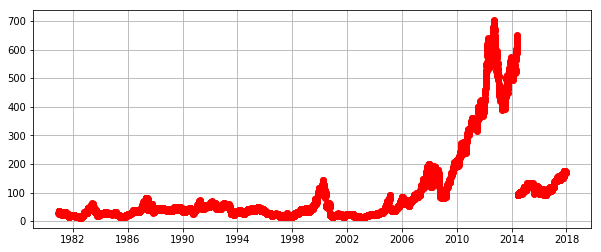

In [5]:
# plotting the trend of opening price during time
plt.figure(figsize=(10,4)) # change the plot figure size (make it bigger than default)
plt.grid(True) # provide a grid (white lines) in the background
plt.plot(data['Open'],"ro") # make the line red andplotted with "o"s (check also "g-")
plt.show() # we may not use this anymore, as we have imported the magic with libraries

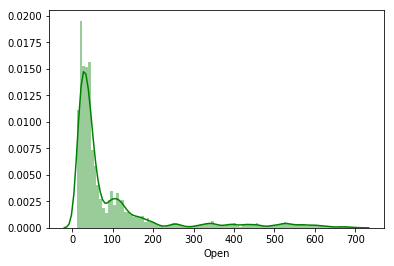

In [6]:
# what's more interesting to see is the distribution of opening prices
sns.distplot(data['Open'],bins=100,color="green")

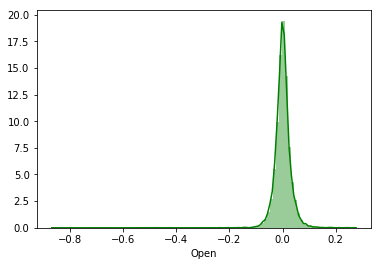

In [7]:
# and what's even more interesting is to see the distribution
# of changes of the opening price
# for that reason let's calculat ethe percentage change in opening price
# using pct_change() function
# but without forgetting that there is no change for the very first row
# so it will become a N/A value (not available), which we need to drop
# using dropna() function
sns.distplot(data['Open'].pct_change().dropna(),bins=100,color="green")

As you can see above the change in openinng prices is following a "pretty normal" distribution with mean close or equal to 0 (in average there is no significant day to day change in the price). This is something we could expect from tock market.

Let's now define a **stock_simulator()** function, that will get some arguments, and based on that simulate future price. The arguments are:

- starting_price - the price that Monte Carlo simulation will start from. This is usually the last observed price (e.g. today's opening price for the stock).
- periods - number of periods you want to make simulation on. It can be given in days, weeks, etc., but what is important is to remember your own unit of measurement when calculating other parameters (we will use days, and simulate for one year = 365 days).
- mean - the average change in price (that was said to be close to 0).
- std - the standard deviation of the change in price.

*Please note, that mean and std should not necessarely be calcualted on the whole dataset. If you think that prices of this or that stock have considerably change dof let's say 20 years, but have been almost constant during last 5, you may use the mean and std during last 5 years, as old prices may not be representative anymore. For simplicity we will calculate mean and std on the whole dataset.*

Stock price change, according to GBM model, is assumed to depend on two things: drift (the deterministic component) and shock (the stochastic component). **Drift** is showing the trend, and is calculated as mean/periods, i.e. you assume that for future periods you observe the increase trends will be the same as mean, so you spread the latter over that periods. Shock, on the other hand, is assumed to be the random change in stock price around the drift (generated randomly using drift and standard error of drift). Thus, any current/future price can be calulated as follows:
```
current_price = previous_price + previous_price*(drift + shock)
```

One last thing, we will plot 2 plots on the same row. In matplotlib those are called subplots and can be generated using the **subplot()** function, where the arguments show number of rows, number of columns and the relative position of plot respectively. For example, subplot(121) is telling Python to generate 1 row on which we are going to plot 2 plots, and right now we are working on 1st one. For the 2nd one we should use subplot(122).

In [8]:
# simulation function
def stock_simulator(starting_price,periods,mean,std):
    X_axis = []
    Y_axis = []
    
    current_period = 1
    previous_price = starting_price
    
    while current_period <= periods:
        
        drift = float(mean)/periods
        shock = np.random.normal(loc=drift,scale=float(std)/np.sqrt(periods))
        
        current_price = previous_price + previous_price*(drift + shock)
        previous_price = current_price
        
        X_axis.append(current_period)
        Y_axis.append(current_price)
        
        current_period = current_period + 1
    
    plt.subplot(121)
    plt.plot(X_axis,Y_axis)
    return Y_axis[-1]

In [9]:
# simulation inputs
starting_price = data["Open"][-1]
periods = 365
mean = data["Open"].pct_change().dropna().mean()
std = data["Open"].pct_change().dropna().std()

Let's now use our function with the inputs above to calulate 1000 different scenarios. For that we create an empty list of outcomes to append it with the future price after each iteration. Then we plot the distribution as 2nd subplot.

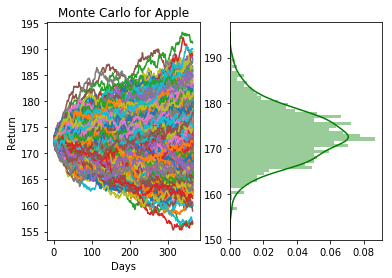

In [10]:
# simulation itself
simulations=0
outcomes = []
while simulations < 1000:
    outcomes.append(stock_simulator(starting_price,periods,mean,std))
    simulations += 1
    
plt.ylabel('Return')
plt.xlabel('Days')
plt.title("Monte Carlo for Apple")
plt.subplot(122)
sns.distplot(outcomes,bins=50,color="green",vertical=True)

Perfect! On the left hand side, we have the simulation, and on the right hand side we have the distribution of future prices (again, pretty normal). So let's take the 2nd graph only, rotate it, and plot the 1st percentile, which will then be used for calculating the VaR.

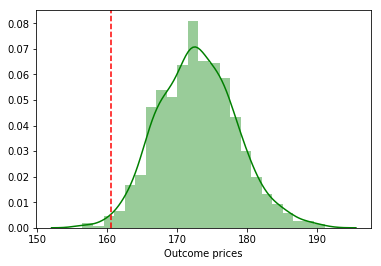

In [11]:
q = np.percentile(outcomes,1) # 1 stands for 1st percentile
sns.distplot(outcomes,color="green",vertical=False,axlabel='Outcome prices')
plt.axvline(q, color="red", linestyle="--") # plot vertical line on that percentile

Now you can see that with 99% confidence, the worst price you may observe in future for this stock is a bit higher than 160. This means that the Value at risk, is you buy only one stock, is Current Price (aroung 174) - that future price (around 161) = around 13. What is more interesting, is to represent it in percentages. Let's do that.

In [12]:
# Calculating VaR coefficient as a percentage change
VaR_coef = (starting_price - q)/starting_price
# decide on how much you want to invest in this stock
investment = 5000
# VaR will cauculate the amoung of money you may end up loosing
# in the worst case scenario, in 99% confidence interval
VaR = VaR_coef*investment
print(VaR)

342.919756539
